In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss
from functools import lru_cache
from scipy.special import eval_legendre, lqmn


# s-SNOM spectra of the bulk samples
This notebook allows users to calculate the near-field spectrum of a bulk homogeneous uniaxial sample **without diving into the full code**.

1. **Geometry & Global Constants** – edit spheroid geometry and oscillation parameters.
2. **Permittivity Models** – define dielectric functions for the reference material and the sample.

## 1. Geometry 
| Variable | Default | Units | Description |
|---------|---------|-------|-------------|
| `R` | 25.0 | nm | Tip curvature radius |
| `L` | 300.0 | nm | Spheroid length |
| `H_MIN_R` | 2.0 | nm | Minimum tip–reference-material gap |
| `H_MIN_S` | 2.0 | nm | Minimum tip–sample gap |
| `A` | 30.0 | nm | Tip oscillation amplitude |


In [2]:
# --- Geometry / global constants ---

# tip geometry 
R = 25.0               # nm
L = 600.0              # nm

# tip osciallation parameters
H_MIN_R = 2.0          # nm
H_MIN_S = 2.0          # nm
A = 30.0               # nm


INCLUDE_FAR_FIELD = True   # ← set True to include the far-field illumination contribution
phi_deg = 45                # angle of incidence [degrees] if enabled


## 2. Permittivity Models 
Set **frequency‑dependent dielectric functions** for:

1. **Reference material**, default = the dielectric permittivity of gold around $\lambda_0=10$ $\mu$m, which works as a perfect electric conductor, as most metals in mid-IR.

In [3]:
# ---- Reference ----
EpsAu_const = -5000.0 + 800.0j  # ε_ref(ω)

def eps_ref(omega_cm: float) -> complex:
    """Reference permittivity ε_ref(ω) in cm^-1."""
    return EpsAu_const

2. **Sample material** (tip–sample gap), default = anysotropic 4H‑SiC Lorentz model.

   $$\varepsilon_{par}(\omega)=\varepsilon_{\infty,par}\left(1+\frac{\omega_{LO,par}^2-\omega_{TO,par}^2}{\omega_{TO,par}^2-\omega^2-i\gamma_{par}\omega}\right)$$
    $$\varepsilon_{per}(\omega)=\varepsilon_{\infty,per}\left(1+\frac{\omega_{LO,per}^2-\omega_{TO,per}^2}{\omega_{TO,per}^2-\omega^2-i\gamma_{per}\omega}\right)$$
    $$ \varepsilon_{eff}(\omega)=\sqrt{\varepsilon_{par}(\omega)\varepsilon_{per}(\omega)} $$

Modify the functions or constants to study other materials (e.g., Drude metals, tabulated data). For isotropic material $ \varepsilon_{eff}(\omega)= \varepsilon(\omega)$.

In [4]:
# ---- Sample ----
Eb_par, Eb_per = 6.78, 6.56
wTO_par, wTO_per = 782.0, 797.0
wLO_par, wLO_per = 967.0, 971.0
gam_par = gam_per = 3.3
wp_par,  wp_per  = 220.0, 275.0
gamp_par = gamp_per = 450.0

def eps_sample(omega_cm: float) -> complex:
    ω = omega_cm
    eps_per = Eb_per * (1 + (wLO_per**2 - wTO_per**2)/(wTO_per**2 - ω**2 - 1j*gam_per*ω)
                        - wp_per**2 / (ω**2 + 1j*ω*gamp_per))
    eps_par = Eb_par * (1 + (wLO_par**2 - wTO_par**2)/(wTO_par**2 - ω**2 - 1j*gam_par*ω)
                        - wp_par**2 / (ω**2 + 1j*ω*gamp_par))
    eps_eff = np.sqrt(eps_par * eps_per)
    return eps_eff if np.imag(eps_eff) >= 0 else -eps_eff

## 3. Define wavenumber range and number of points

In [5]:
M = 101 # number of points in the spectrum
om = np.linspace(850.0, 1050.0, M)  # cm⁻¹

## 4. Calculation

In [6]:


"""-------------------------------------------------------------------------
Spheroid–spectrum simulator  •  far‑field option added
-------------------------------------------------------------------------
* Computes near‑field tip–sample harmonics (2ω, 3ω, 4ω) for a spheroidal tip.
* Reference **and** sample permittivities can vary with frequency.
* "INCLUDE_FAR_FIELD" (True/False) multiplies the incident field by
  the Fresnel factor "(1 + r_p)^2 sin φ".
"""


##############################################################################
# 1. Legendre helpers                                                        #
##############################################################################
@lru_cache(maxsize=None)
def P(n: int, x: float):
    return eval_legendre(n, x)

@lru_cache(maxsize=None)
def Q(n: int, x: float):
    return lqmn(0, n, x)[0][0, n]

##############################################################################
# 2. Geometry & constants                                                    #
##############################################################################
EPS0 = 8.85418782e-12    # F m⁻¹
a=L/2
c = np.sqrt(a * (a - R))

H0_R = A + H_MIN_R
H0_S = A + H_MIN_S

E0 = 4 * np.pi * EPS0    # base incident field amplitude
EpsT = -1e10             # PEC‑like tip permittivity



##############################################################################
# 4. Numerical grid                                                          #
##############################################################################

N = 50
m = 20

nodes, weights = leggauss(64)
P_tab = np.array([eval_legendre(i, nodes) for i in range(m + 1)])

##############################################################################
# 5. Geometry integrals                                                      #
##############################################################################
JR = np.zeros((m, m, N + 1), dtype=np.complex128)
JS = np.zeros_like(JR)
psi_arr = np.pi * np.arange(N + 1) / N

def _fill_J(H0: float, J):
    for k, psi in enumerate(psi_arr):
        H_k = H0 - A * np.cos(psi)
        z_shift = 2*a/c + 2*H_k/c
        num = z_shift - (a/c)*nodes
        base = 1 + num**2 + (a**2/c**2 - 1)*(1 - nodes**2)
        rad = np.sqrt((base + np.sqrt(base**2 - 4*num**2))/2)
        arg = num / rad
        Q_mat = np.array([[Q(j, r) for r in rad] for j in range(m + 1)])
        for i in range(1, m + 1):
            Pi = P_tab[i]
            for j in range(1, m + 1):
                J[i-1, j-1, k] = weights @ (Pi * eval_legendre(j, arg) * Q_mat[j])

print("Building geometry tensors …")
_fill_J(H0_R, JR)
_fill_J(H0_S, JS)

##############################################################################
# 6. Geometry‑only denominators                                              #
##############################################################################
P_ac = np.array([P(i, a/c) for i in range(m + 1)])
Q_ac = np.array([Q(i, a/c) for i in range(m + 1)])

denom_i = np.array([
    np.nan if i == 0 else (
        EpsT*Q_ac[i]/P_ac[i] - (a/c*Q_ac[i]-Q_ac[i-1])/(a/c*P_ac[i]-P_ac[i-1])
    ) for i in range(m + 1)
], dtype=np.complex128)
const_ref = EpsT*Q_ac[1] - a/c*Q_ac[0] + a**2/(a**2 - c**2)

##############################################################################
# 7. Far‑field Fresnel factor helper                                         #
##############################################################################
phi = np.deg2rad(phi_deg)
cos_phi = np.cos(phi)

def fresnel_factor(eps: complex) -> float:
    """Return |(1 + r_p)^2 sin φ|, where r_p is the p‑polarised Fresnel refl."""
    if not INCLUDE_FAR_FIELD:
        return 1.0
    kz1 = cos_phi  # medium 1 = air (n≈1)
    kz2 = np.sqrt(eps - np.sin(phi)**2)
    rp = (eps/kz2 - 1/kz1) / (eps/kz2 + 1/kz1)
    return abs((1 + rp)**2 * np.sin(phi))

##############################################################################
# 8. Harmonic solver                                                         #
##############################################################################

def harmonics(beta: complex, J, E_amp: float):
    C = np.empty((m, 1), dtype=np.complex128)
    acc2 = acc3 = acc4 = 0.0j
    for k in range(N + 1):
        Mat = np.eye(m, dtype=np.complex128)
        Jk = J[:, :, k]
        for i in range(1, m + 1):
            C[i-1, 0] = -beta*(EpsT-1)**2*c*E_amp/4 * Jk[0, i-1] / (P_ac[i]*const_ref*denom_i[i])
            for j in range(1, m + 1):
                Mat[i-1, j-1] -= beta*(EpsT-1)*(2*j+1)/2 * Jk[j-1, i-1] / (P_ac[i]*denom_i[i])
        U = np.linalg.solve(Mat, C)
        pz_k = 2*a*c*U[0,0] - (EpsT-1)*a*c**2*E_amp/3/const_ref
        for n, acc in ((2, 'acc2'), (3, 'acc3'), (4, 'acc4')):
            coef = np.exp(-1j*np.pi*k*n/N)/(2*N) if k in (0, N) else np.cos(np.pi*k*n/N)/N
            if n == 2:
                acc2 += pz_k*coef
            elif n == 3:
                acc3 += pz_k*coef
            else:
                acc4 += pz_k*coef
    return acc2, acc3, acc4

##############################################################################
# 9. Frequency sweep                                                         #
##############################################################################
print("Sweeping frequencies … (far‑field = {} )".format(INCLUDE_FAR_FIELD))

pz2_ref = np.zeros(M, dtype=np.complex128)
pz3_ref = np.zeros(M, dtype=np.complex128)
pz4_ref = np.zeros(M, dtype=np.complex128)
pz2_sam = np.zeros_like(pz2_ref)
pz3_sam = np.zeros_like(pz2_ref)
pz4_sam = np.zeros_like(pz2_ref)

for idx, w in enumerate(om):
    eps_r = eps_ref(w)
    eps_s = eps_sample(w)
    beta_r = (eps_r - 1)/(eps_r + 1)
    beta_s = (eps_s - 1)/(eps_s + 1)
    E_r = E0 * fresnel_factor(eps_r)
    E_s = E0 * fresnel_factor(eps_s)
    pz2_ref[idx], pz3_ref[idx], pz4_ref[idx] = harmonics(beta_r, JR, E_r)
    pz2_sam[idx], pz3_sam[idx], pz4_sam[idx] = harmonics(beta_s, JS, E_s)



Building geometry tensors …
Sweeping frequencies … (far‑field = True )


In [7]:
# 9. Amplitude & phase (unwrap)                                              #


Ampl2 = np.abs(pz2_sam / pz2_ref)
Ampl3 = np.abs(pz3_sam / pz3_ref)
Ampl4 = np.abs(pz4_sam / pz4_ref)

Phase2 = np.angle(pz2_sam / pz2_ref)
Phase3 = np.angle(pz3_sam / pz3_ref)
Phase4 = np.angle(pz4_sam / pz4_ref)

for Phase in (Phase2, Phase3, Phase4):
    Phase[:] = np.unwrap(Phase)



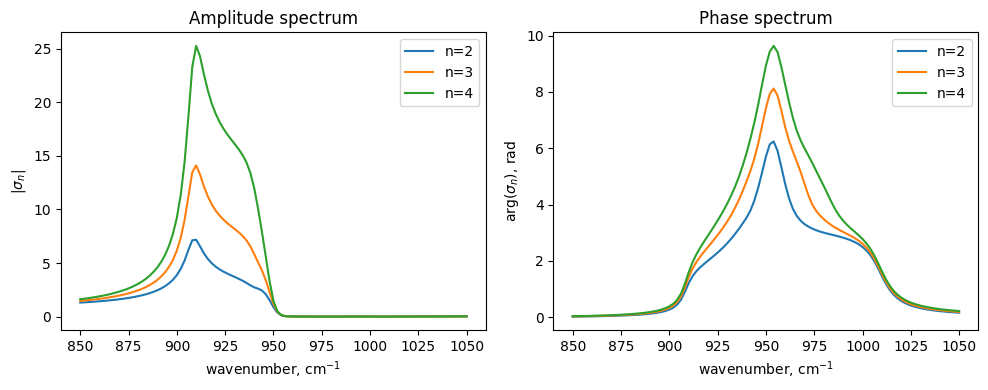

In [14]:
# 10. Plot                                                                   #

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(om, Ampl2, label='n=2')
plt.plot(om, Ampl3, label='n=3')
plt.plot(om, Ampl4, label='n=4')
plt.xlabel('wavenumber, cm$^{-1}$')
plt.ylabel('$|\sigma_n|$')
plt.title('Amplitude spectrum')
plt.legend()

plt.subplot(1,2,2)
plt.plot(om, Phase2, label='n=2')
plt.plot(om, Phase3, label='n=3')
plt.plot(om, Phase4, label='n=4')
plt.xlabel('wavenumber, cm$^{-1}$')
plt.ylabel('arg$(\sigma_n)$, rad')
plt.title('Phase spectrum')
plt.legend()
plt.tight_layout()
plt.show()